In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import yaml
from datasets import load_from_disk
from utils import parse_model_results, process_mutation_dataset, task2muts

from consts import (
    CORECEPTOR_CMAP,
    CORECEPTOR_ORDER,
    DRUG_CMAP,
    DRUG_ORDER,
    HALF_PAGE_FIGSIZE,
    MODEL_CMAP,
    MODEL_FANCY_NAMES,
    MODEL_FANCY_ORDER,
    TASK_FANCY_NAMES,
    TASK_FANCY_ORDER,
    TISSUE_CMAP,
    TISSUE_ORDER,
    CORECEPTOR_NEUTRAL_MUTS,
    CORECEPTOR_EFFECT_MUTS,
    RESIST_EFFECT_MUTS,
    RESIST_NEUTRAL_MUTS
)


In [2]:
def process_downsample_concept_paths(files):
    data = []
    for path in files:
        parts = path.split("/")
        stem = parts[-4]
        model, prot, task = stem.split("_")
        fold = parts[-3]
        ds = int(parts[-2])
        row_info = {"fold": fold, "model": model, "prot": prot, "task": task, 'DS': ds}

        effect_muts, neutral_muts = task2muts(task)
        dataset = load_from_disk(path)
        
        data.append(process_mutation_dataset(dataset, effect_muts,
                                             neutral_muts, loss_only=True))
        for key, val in row_info.items():
            data[-1][key] = val
            
    return pd.concat(data, axis=0, ignore_index=True)



In [3]:
full_pattern = "../models/*/*/best.yaml"
full_files = glob.glob(full_pattern)

ds_pattern = "../downsample/*/*/*-best.yaml"
ds_files = glob.glob(ds_pattern)

concept_files = glob.glob('../downsample/*/*/*/concept')

all_df = pd.concat([parse_model_results(full_files),
                    parse_model_results(ds_files),
                    process_downsample_concept_paths(concept_files)],
                   axis=0, ignore_index=True)
all_df = all_df.replace({'task':TASK_FANCY_NAMES, 'model': MODEL_FANCY_NAMES})
all_df.head()

,fold,model,prot,task,DS,metric,field,value
0,0,TF-IDF,PR,Protease\nResistance,Full,acc,FPV,0.857143
1,0,TF-IDF,PR,Protease\nResistance,Full,auc,FPV,0.935297
2,0,TF-IDF,PR,Protease\nResistance,Full,f1,FPV,0.811245
3,0,TF-IDF,PR,Protease\nResistance,Full,precision,FPV,0.795276
4,0,TF-IDF,PR,Protease\nResistance,Full,recall,FPV,0.827869


In [6]:
piv_df = pd.pivot_table(all_df,
                        index=['fold', 'model', 'prot', 'task', 'DS'],
                        columns=['metric', 'field'],
                        values='value',
                        aggfunc='first')['concept_loss'].reset_index()
piv_df.head()

field,fold,model,prot,task,DS,CCR5,CXCR4,FPV,IDV,NFV,SQV
0,0,HIV-BERT,PR,Protease\nResistance,25,NaN,NaN,NaN,NaN,NaN,NaN
1,0,HIV-BERT,PR,Protease\nResistance,100,NaN,NaN,NaN,NaN,NaN,NaN
2,0,HIV-BERT,PR,Protease\nResistance,Full,NaN,NaN,NaN,NaN,NaN,NaN
3,0,HIV-BERT,V3,Coreceptor,Full,NaN,NaN,NaN,NaN,NaN,NaN
4,0,HIV-BERT,V3,Tissue,Full,NaN,NaN,NaN,NaN,NaN,NaN


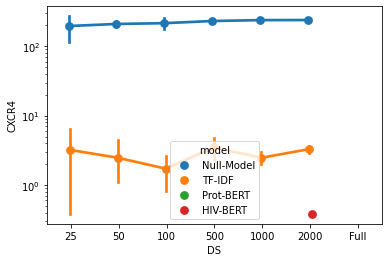

In [8]:
ax = sns.pointplot(data=piv_df,
                              x='DS',
                   order = [25, 50, 100, 500, 1000, 2000, 'Full'],
                              y='CXCR4',
                              hue='model',
                              hue_order=MODEL_FANCY_ORDER,
                              dodge=True)
ax.set_yscale('log')